In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn

# 图像预处理：数据增强和标准化
transform = transforms.Compose([
    transforms.Resize((224, 224)),            # 将图像缩放为224x224大小
    transforms.RandomHorizontalFlip(),        # 随机水平翻转
    transforms.RandomRotation(20),            # 随机旋转
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机平移
#    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机调整图像亮度、对比度、饱和度
    transforms.ToTensor(),                    # 将图像转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 数据标准化
])

# 自定义数据集类，用于加载图像和标签
class TinySegDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        
        # 读取标签文件
        with open(annotations_file, 'r') as f:
            self.annotations = f.readlines()
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        line = self.annotations[idx].strip()
        img_name, label = line.split(": ")
        img_path = os.path.join(self.img_dir, img_name)
        
        # 打开图像
        image = Image.open(img_path).convert('RGB')
        
        # 应用预处理
        if self.transform:
            image = self.transform(image)
        
        return image, int(label)

# 实例化数据集
annotations_file = r"C:\Users\Yet Young\Desktop\documents\ML\tiny_seg_exp\TinySeg\labels.txt"  # 替换为你的标签文件路径
img_dir = r"C:\Users\Yet Young\Desktop\documents\ML\tiny_seg_exp\TinySeg\JPEGImages"  # 图像所在的目录
dataset = TinySegDataset(annotations_file, img_dir, transform)

# 切分数据集
test_size = 624
train_size = len(dataset) - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 查看类别分布
labels = [int(line.strip().split(": ")[1]) for line in open(annotations_file)]
label_counts = {i: labels.count(i) for i in set(labels)}  # 统计每个类别的样本数量

# 计算每个类别的采样权重
class_weights = {i: 1.0 / count for i, count in label_counts.items()}
weights = [class_weights[label] for label in labels[:train_size]] # 根据每个图像的标签分配权重

# 创建 WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class VGGVOC(pl.LightningModule):
    def __init__(self):
        super(VGGVOC, self).__init__()

        # 定义卷积块 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 输入通道为 3，输出通道为 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 尺寸减半, 输入为 224x224, 输出为 112x112
        )
        
        # 定义卷积块 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 输入 64，输出 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 输入为 112x112, 输出为 56x56
        )

        # 定义卷积块 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 输入 128，输出 256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 输入为 56x56, 输出为 28x28
        )
        
        # 定义卷积块 4
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 输入 256，输出 512
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 输入为 28x28, 输出为 14x14
        )

        # 定义卷积块 5
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 输入 512，输出 512
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 输入为 14x14, 输出为 7x7
        )

        # 全连接层
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)  # 输入尺寸为 512 * 7 * 7 = 25088
        self.fc2 = nn.Linear(4096, 4096)  # 第二层全连接
        self.fc3 = nn.Linear(4096, 5)  # 最终输出 5 类（调整为5类）

        # Dropout层
        self.dropout = nn.Dropout(p=0.5)  # 设置50%的dropout率

        # 损失函数
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        # 前向传播
        x = self.conv_block1(x)  # 卷积块 1
        x = self.conv_block2(x)  # 卷积块 2
        x = self.conv_block3(x)  # 卷积块 3
        x = self.conv_block4(x)  # 卷积块 4
        x = self.conv_block5(x)  # 卷积块 5
        x = x.view(x.size(0), -1)  # 展平
        x = F.relu(self.fc1(x))  # 全连接层 1
        x = self.dropout(x)  # 添加Dropout
        x = F.relu(self.fc2(x))  # 全连接层 2
        x = self.fc3(x)  # 全连接层 3
        return x

    def training_step(self, batch, batch_no):
        # 训练步骤
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        accuracy = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)
        return loss

    def configure_optimizers(self):
        # 使用RMSprop优化器并加入L2正则化
        return torch.optim.RMSprop(self.parameters(), lr=0.00002, weight_decay=1e-4)


In [4]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_path = "vgg_voc_trained.pt"
model = VGGVOC.load_from_checkpoint(checkpoint_path);
logger = TensorBoardLogger("voc_logs", name="vgg")
trainer = pl.Trainer(
    devices=1,           
    accelerator='gpu', 
    max_epochs=10, # set number of epochs
   enable_progress_bar=True,
   logger=logger 
)
trainer.fit(model, train_loader)
# 保存训练好的模型
trainer.save_checkpoint("vgg_voc_trained.pt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | conv_block1 | Sequential       | 1.8 K  | train
1 | conv_block2 | Sequential       | 73.9 K | train
2 | conv_block3 | Sequential       | 295 K  | train
3 | conv_block4 | Sequential       | 1.2 M  | train
4 | conv_block5 | Sequential       | 2.4 M  | train
5 | fc1         | Linear           | 102 M  | train
6 | fc2         | Linear           | 16.8 M 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [10]:
from tqdm import tqdm
# 加载训练后的模型
inference_model = VGGVOC.load_from_checkpoint("vgg_voc_trained.pt", map_location="cuda")
inference_model.eval()  # 设置为评估模式

# 推断函数
def get_prediction(x, model: pl.LightningModule):
    model.freeze()  # 准备模型进行预测
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

# 进行推断
true_y, pred_y = [], []

for batch in tqdm(test_loader, total=len(test_loader)):
    x, y = batch
    x = x.to("cuda")  # 将数据放到GPU

    # 获取预测结果
    preds, _ = get_prediction(x, inference_model)
    
    true_y.extend(y.cpu().numpy())  # 收集真实标签
    pred_y.extend(preds.cpu().numpy())  # 收集预测标签

# 输出分类报告
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

              precision    recall  f1-score   support

           0      0.891     0.961     0.925        51
           1      0.870     0.833     0.851        48
           2      0.942     0.887     0.914       328
           3      0.929     0.893     0.911       103
           4      0.748     0.915     0.823        94

    accuracy                          0.894       624
   macro avg      0.876     0.898     0.885       624
weighted avg      0.901     0.894     0.896       624



100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


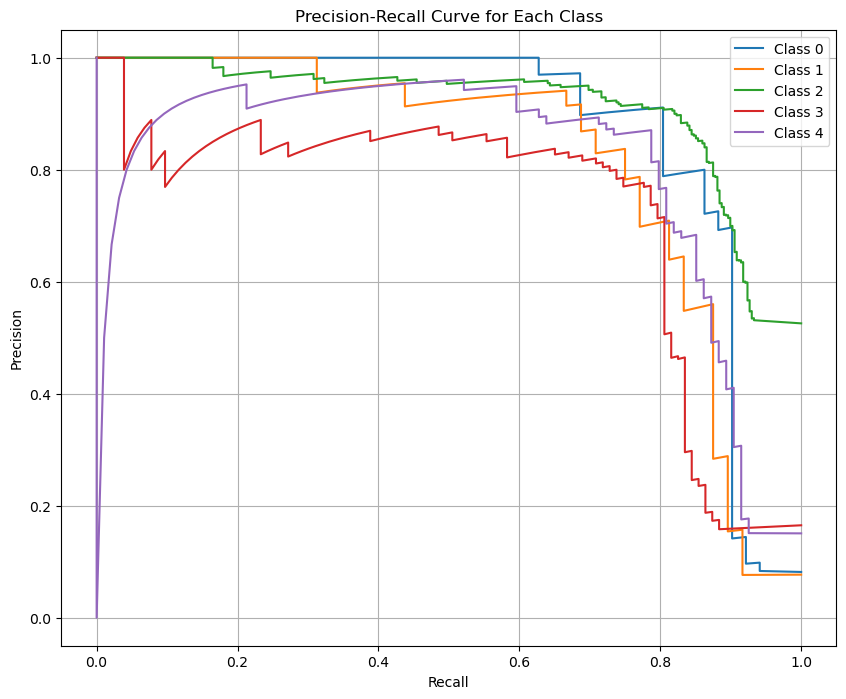

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np

# 1. 对标签进行二值化处理
true_y_binarized = label_binarize(true_y, classes=[0, 1, 2, 3, 4])  # 假设有5个类别，标签为0-4
pred_probs = np.zeros((len(true_y), 5))  # 用于存储每个类别的预测概率

# 2. 获取每个样本在每个类别上的预测概率
for batch_idx, batch in enumerate(tqdm(test_loader, total=len(test_loader))):
    x, _ = batch
    x = x.to("cuda")
    
    with torch.no_grad():
        preds = inference_model(x)  # 获取模型输出
        preds = torch.softmax(preds, dim=1)  # 计算每个类别的概率
        pred_probs[batch_idx * len(x):(batch_idx + 1) * len(x)] = preds.cpu().numpy()

# 3. 绘制每个类别的PR曲线
plt.figure(figsize=(10, 8))
for i in range(5):  # 假设类别数量为5
    precision, recall, _ = precision_recall_curve(true_y_binarized[:, i], pred_probs[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="best")
plt.grid(True)
plt.show()
